In [104]:
import os
import regex
import glob
import multiprocessing as mp

from functools import partial, reduce

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pdf2image.exceptions import (
    PDFInfoNotInstalledError,
    PDFPageCountError,
    PDFSyntaxError
)

from pdf2image import convert_from_path, convert_from_bytes
import matplotlib.pyplot as plt
import cv2 as cv
import pytesseract

In [42]:
path = os.path.abspath('analisis_clinicos/')
path

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos'

In [50]:
caminos = glob.glob(f"{path}/*.pdf")
caminos

['/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2018-05-13.pdf',
 '/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2018-05-06.pdf',
 '/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2019-11-13.pdf',
 '/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/Wed Nov 13 18:05:58 CST 2019.pdf',
 '/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/InformeResultados1-110600.pdf',
 '/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2018-01-19.pdf']

In [53]:
archivos = [ os.path.split(camino)[1] for camino in caminos]
archivos

['gustavo_maganna_2018-05-13.pdf',
 'gustavo_maganna_2018-05-06.pdf',
 'gustavo_maganna_2019-11-13.pdf',
 'Wed Nov 13 18:05:58 CST 2019.pdf',
 'InformeResultados1-110600.pdf',
 'gustavo_maganna_2018-01-19.pdf']

In [ ]:
#pool.close()
#pool.terminate()

In [45]:
pool = mp.Pool()

In [56]:
imagenes = pool.map(convert_from_path, caminos)

In [57]:
archivos_en_imagenes = {
    archivo: imagen for archivo, imagen in zip(archivos, imagenes)
}

In [65]:
archivos_en_imagenes[archivos[0]]

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1660x2339 at 0x124712F50>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1660x2339 at 0x124712850>,
 <PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1660x2339 at 0x1247120D0>]

In [64]:
strings = {
    nombre: pool.map(pytesseract.image_to_string, archivo) for nombre, archivo in archivos_en_imagenes.items()
}

In [215]:
# Sent all of these files to texts/
for nombre, hojas in strings.items():
    for i, hoja in enumerate(hojas):
        _file_name = f"{nombre.replace('.pdf', '')}.{i}.txt"
        with open(_file_name, "w") as f:
                  f.write(hoja)

In [250]:
for lista in strings.values():
    for string in lista:
        print(regex.findall(r"\d\d.\d\d.\d\d\d\d", string))

['01477 7885', '06/08/1996', '13/05/2018', '1002040012', '13/05/2018']
['01477 7885', '06/08/1996', '13/05/2018', '1002040012', '13/05/2018']
['01477 7885', '06/08/1996', '13/05/2018', '1002040012', '13/05/2018']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']
['06/08/1996']


In [205]:
_file = archivos[1]
print(_file)
#print(strings[_file][0])

gustavo_maganna_2018-05-06.pdf


In [245]:
_file = archivos[1]
print(_file)
foo = strings[_file][1]
# Split by line breaks :
foo_lines = foo.split("\n")
# Select valid lines (i.e. lionge than 5 characters) :
foo_lines = [ line for line in foo_lines ] # if len(line) > 1 ]

#regex.compile(r'[A-Z]')
print(foo_lines[10])
for i in regex.finditer(r"^[A-Z]*", foo_lines[14]):
    print(foo_lines[14])
    #print(dir(i))
    print(i)


gustavo_maganna_2018-05-06.pdf
 

<regex.Match object; span=(0, 0), match=''>


In [246]:
#print(foo)

In [247]:
# My regexps :

may_ge_2 = r"^[A-Z]{2,}"  # Find CAPITAL WORDS longer than 2, at the begining of the line.
numbers = r"(\d+\.\d+|\d+)" # Find numbers of any length, with a decimal point or not.
from_begining_until_point = r"^.+?(?=(\..+))" # Find any text before the first occurrence of a pint
failed_extract_units = r"(?<=((\d+\.\d+|\d+)+))(.+)"


In [261]:
for line in foo_lines[14:]:
    for i in regex.finditer(r"^.+?(?=(\..+))", line): # FIND lines starting with Caps 
        print(i.string)
        print('\t',i.group())
        for j in regex.finditer(r"(\d+\.\d+|\d+)", i.string): # find groups of numbers
            print(2*'\t',j.group())
            # (?<=\[).+?(?=\])
        for k in regex.finditer(r"(?<=(\d+\.\d+|\d+)).+?(?=(\d+\.\d+|\d+))", i.string):
            print(3*'\t',k.group())

Fecha Nac.:06/08/1996 Fecha ingreso: 6-MAY-2018 09:20 AM_ Fecha—Hora ler Impresion:6-MAY-2018 01:34 PM
	 Fecha Nac
		 06
		 08
		 1996
		 6
		 2018
		 09
		 20
		 6
		 2018
		 01
		 34
			 6/
			 8/
			 9
			 9
			 6 Fecha ingreso: 
			 -MAY-
			 0
			 1
			 8 
			 9:
			 0 AM_ Fecha—Hora ler Impresion:
			 -MAY-
			 0
			 1
			 8 
			 1:
Médico:JUAN CARLOS FERRER SERRANO peel H. ARANDA DE LA Ultima Impresion: 6-MAY-2018 07:58 PM
	 Médico:JUAN CARLOS FERRER SERRANO peel H
		 6
		 2018
		 07
		 58
			 -MAY-
			 0
			 1
			 8 
			 7:
. U. de :
	 . U
GLUCOSA.Q.. oc essessessesstesssessseesstesseeseee 68 mg/dL J 70 - 100
	 GLUCOSA
		 68
		 70
		 100
			 8 mg/dL J 
			 0 - 
			 0
NITROGENO UREICO 17.1 mg/dL 8-26
	 NITROGENO UREICO 17
		 17.1
		 8
		 26
			 7.
			  mg/dL 
			 -
CREATININA.. te 0.76 mg/dL 0.61 - 1.24
	 CREATININA
		 0.76
		 0.61
		 1.24
			 .
			 6 mg/dL 
			 .
			 1 - 
			 .
ACIDO URICO. 4.9 mg/dL 4.80 - 8.70
	 ACIDO URICO
		 4.9
		 4.80
		 8.70
			 .
			  mg/dL 
			 .
			 0

In [221]:
for line in foo_lines:
    for i in regex.findall(r"^[A-Z]{2,}", line):
        print(i)

LABORATORIO
ANIVERSARIO
HOSPITAL
TODA
EXAMEN
EXAMEN
VOLUMEN
AMARILLO
TRANSPARENTE
DENSIDAD
EXAMEN
GLUCOSA
PROTEINAS
ACETONA
HEMOGLOBINA
PIG
ESTERASA
NITRITOS
UROBILINOGENO
EXAMEN
LEUCOCITOS
ERITROCITOS
CRISTALES
CILINDROS
CELS
BACTERIAS
LEVADURAS
METODOLOGIA
TIPO
NOTA


In [152]:
dir(i)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'captures',
 'capturesdict',
 'detach_string',
 'end',
 'endpos',
 'ends',
 'expand',
 'expandf',
 'fuzzy_changes',
 'fuzzy_counts',
 'group',
 'groupdict',
 'groups',
 'lastgroup',
 'lastindex',
 'partial',
 'pos',
 're',
 'regs',
 'span',
 'spans',
 'start',
 'starts',
 'string']

In [161]:
i.expand()

TypeError: expand() takes exactly one argument (0 given)

In [129]:
help(regex.compile)

Help on function compile in module regex.regex:

compile(pattern, flags=0, **kwargs)
    Compile a regular expression pattern, returning a pattern object.



In [128]:
regex.compile()

TypeError: compile() missing 1 required positional argument: 'pattern'

In [93]:
[
    reduce(lambda x, y: x + y if y.isupper() else x, line, '')
    for line in woo
]

['LABORATORIODEPATOLOGIACLINICA',
 'HOSPITAL',
 '',
 'AVENIDAHIDALGONCPLEONGTO',
 'ARANDADELAPARRADIRCONMEXTYTELFAX',
 '',
 'TODALAVIDACONTIGO',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 'PGUSTAVOMAGANALOPEZEANOSSMASCULINOCC',
 'EFSEXTERNO',
 'FNFMAYAMFHIMAYPM',
 'MJUANCARLOSFERRERSERRANOHARANDADELAUIMAYPM',
 'U',
 'ERMIR',
 'BIOMETRIAHEMATICAV',
 'FORMULAROJA',
 'HEMOGLOBINAL',
 'HEMATOCRITOT',
 'L',
 'ERITROCITOST',
 'VCML',
 '',
 '',
 'FORMULABLANCA',
 'LEUCOCITOSML',
 'DIFERENCIALLEUCOCITARIA',
 'LINFOCITOS',
 'MONOCITOS',
 'EOSINOFILOS',
 'BASOFILOS',
 'SEGMENTADOS',
 'BANDAS',
 'VALORESABSOLUTOS',
 'LINFOCITOSML',
 'MONOCITOSML',
 'EOSINOFILOSML',
 'BASOFILOSML',
 'NEUTROFILOSML',
 'PLAQUETASML',
 'METODOLOGIACIANOMETAHEMOGLOBINAIMPEDANCIAYRAYOLASER',
 'TIPODEMUESTRASANGRETOTALCONEDTA',
 '',
 'A',
 '',
 'VQFBMARIAGUADALUPEMUNOZVELAZQUEZ',
 'NOTAEC',
 'RDGAOPCUANL

In [95]:
#dir('')

In [101]:
x = "\n hola \n"

In [103]:
r"{}".format(x)

'\n hola \n'

In [99]:
print(r'\n\nhola')

\n\nhola


In [74]:
with open('watever', 'w') as lol:
    lol.write(strings[archivos[2]][0])

In [75]:
# Cuántas líneas tenemos en total :
caracteres_por_linea = pd.core.series.Series(
    [
     len(line) for line in page.split('\n') 
     for pdf in strings 
     for page in pdf
    ],
    name='caracteres'
)

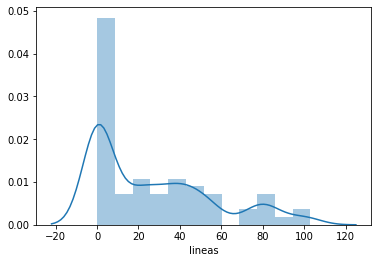

In [76]:
sns.distplot(caracteres)

In [36]:
archivos[0]

'/Users/gml/Documents/IX/imagenes/FinalDeImagenes/analisis_clinicos/gustavo_maganna_2018-05-13.pdf'

In [34]:
if False:
    for pdf in strings:
        for page in pdf:
            print(page)